# Preparing Alpha Factors and Features to predict Stock Returns

## Imports & Settings

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from talib import RSI, BBANDS, MACD, ATR

In [2]:
MONTH = 21
YEAR = 12 * MONTH

In [3]:
START = '2013-01-01'
END = '2017-12-31'

In [4]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

## Loading Quandl Wiki Stock Prices & Meta Data

In [9]:
DATA_STORE = '../data/assets.h5'
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :],
                   ['adj_open', 'adj_close', 'adj_low', 
                    'adj_high', 'adj_volume']]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .swaplevel()
              .sort_index())
    prices.volume /= 1e3
    stocks = (store['us_equities/stocks']
              .loc[:, ['marketcap', 'ipoyear', 'sector']])

## Remove stocks with few observations

In [10]:
min_obs = 2 * YEAR
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

### Align price and meta data

In [11]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [12]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [13]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2748774 entries, (A, 2013-01-02 00:00:00) to (ZUMZ, 2017-12-29 00:00:00)
Data columns (total 5 columns):
open      2748774 non-null float64
close     2748774 non-null float64
low       2748774 non-null float64
high      2748774 non-null float64
volume    2748774 non-null float64
dtypes: float64(5)
memory usage: 115.5+ MB


In [14]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2224 entries, A to ZUMZ
Data columns (total 3 columns):
marketcap    2222 non-null float64
ipoyear      962 non-null float64
sector       2224 non-null object
dtypes: float64(2), object(1)
memory usage: 69.5+ KB


In [50]:
stocks.sector.value_counts()

consumer_services        415
finance                  368
technology               284
health_care              276
capital_goods            225
basic_industries         133
consumer_non-durables    120
energy                   114
public_utilities          98
consumer_durables         74
miscellaneous             63
transportation            54
Name: sector, dtype: int64

## Compute Rolling Average Dollar Volume

In [16]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices.loc[:, 'close'].mul(prices.loc[:, 'volume'], axis=0)
prices['dollar_vol'] = (prices
                        .groupby('ticker',
                                 group_keys=False,
                                 as_index=False)
                        .dollar_vol
                        .rolling(window=21)
                        .mean()
                        .fillna(0)
                        .reset_index(level=0, drop=True))
prices.dollar_vol /= 1e3

In [17]:
prices['dollar_vol_rank'] = (prices
                             .groupby('date')
                             .dollar_vol
                             .rank(ascending=False))

## Add some Basic Factors

### Compute the Relative Strength Index

In [19]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

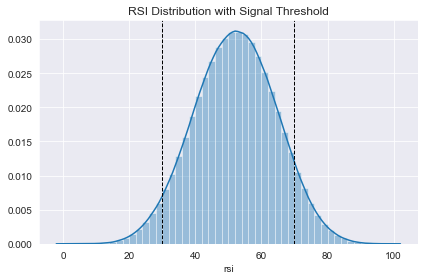

In [20]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [21]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [22]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [23]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

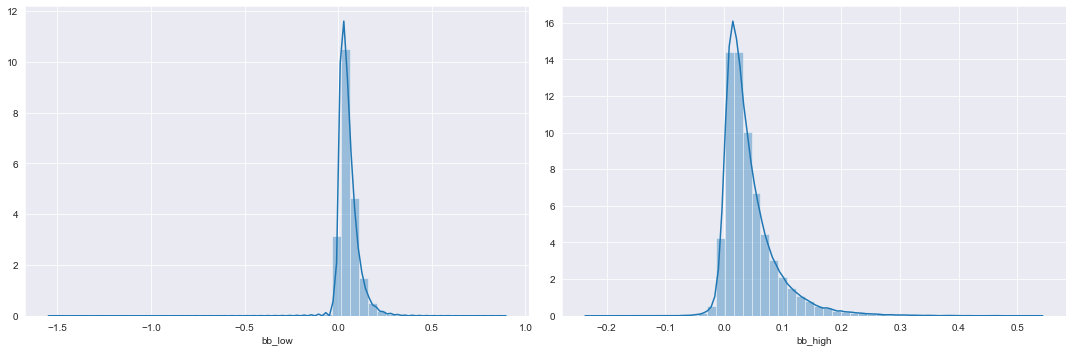

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [25]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [26]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

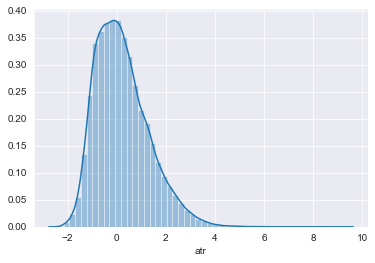

In [27]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

### Compute Moving Average Convergence/Divergence

In [28]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [29]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [30]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    2,675,382.0
mean            -0.0
std              1.0
min            -10.5
0.1%            -4.1
1%              -2.6
2%              -2.2
3%              -2.0
4%              -1.8
5%              -1.6
50%              0.0
95%              1.6
96%              1.7
97%              1.9
98%              2.1
99%              2.6
99.9%            4.0
max              8.7
Name: macd, dtype: object

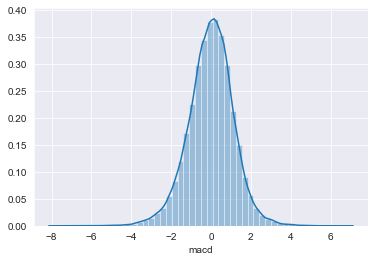

In [31]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## Compute Lagged Returns

In [32]:
lags = [1, 5, 10, 21, 42, 63]

In [33]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,9.53%
min,-87.57%
0.01%,-32.88%
0.1%,-14.69%
1%,-6.47%
50%,0.04%
99%,6.92%
99.9%,16.87%
99.99%,39.26%
max,"10,280.40%"


In [34]:
q = 0.0001

In [35]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift lagged returns

In [36]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

## Compute Forward Returns

In [37]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [38]:
prices = prices.join(stocks[['sector']])

## Create time and sector dummy variables

In [39]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [40]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [41]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2748774 entries, (A, 2013-01-02 00:00:00) to (ZUMZ, 2017-12-29 00:00:00)
Data columns (total 68 columns):
open                     2748774 non-null float64
close                    2748774 non-null float64
low                      2748774 non-null float64
high                     2748774 non-null float64
volume                   2748774 non-null float64
dollar_vol               2748774 non-null float64
dollar_vol_rank          2748774 non-null float64
rsi                      2717638 non-null float64
bb_high                  2706515 non-null float64
bb_low                   2706486 non-null float64
atr                      2717638 non-null float64
macd                     2675382 non-null float64
return_1d                2746550 non-null float64
return_5d                2737654 non-null float64
return_10d               2726534 non-null float64
return_21d               2702070 non-null float64
return_42d               2655366 non-null fl

## Store Model Data

In [42]:
prices.to_hdf('data.h5', 'model_data')

## Explore Data

### Plot Factors

In [43]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

### RSI

In [44]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [45]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4154.0,0.001213,0.010133,-0.054536,-0.003448,0.001104,0.006196,0.046050
"(30, 70]",107329.0,0.000468,0.007559,-0.164788,-0.003036,0.000649,0.004244,0.075653
"(70, 100]",10599.0,0.000017,0.006344,-0.087857,-0.002828,0.000138,0.003104,0.058570


### Bollinger Bands

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


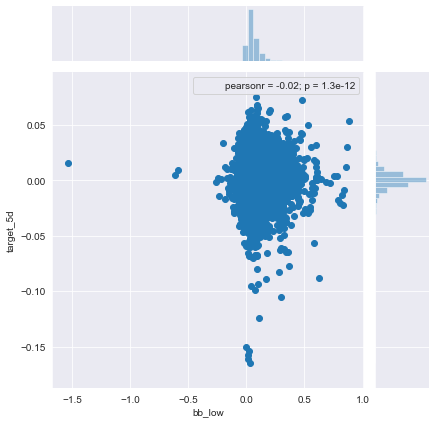

In [46]:
j=sns.jointplot(x=top100.bb_low, y=target, data=top100)
j.annotate(pearsonr);

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


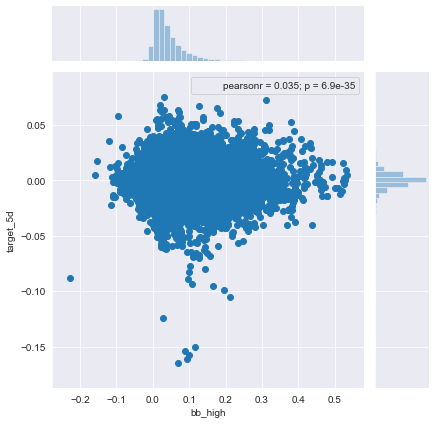

In [47]:
j=sns.jointplot(x='bb_high', y=target, data=top100)
j.annotate(pearsonr);

### ATR

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


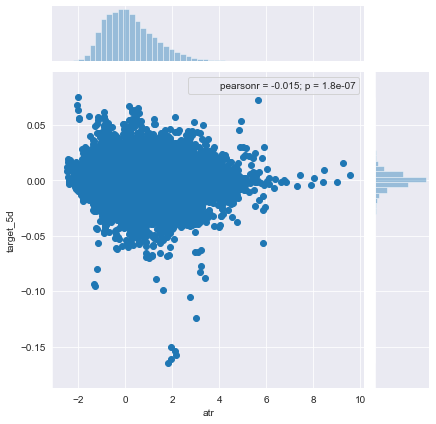

In [48]:
j=sns.jointplot(x='atr', y=target, data=top100)
j.annotate(pearsonr);

### MACD

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


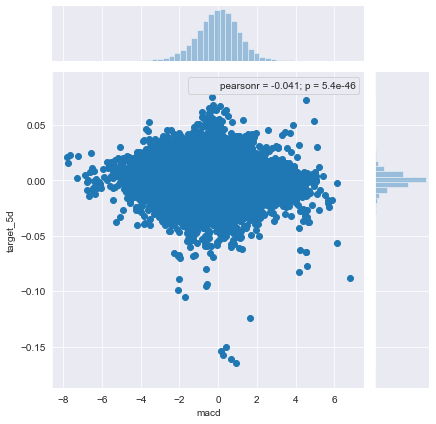

In [49]:
j=sns.jointplot(x='macd', y=target, data=top100)
j.annotate(pearsonr);